# Analysis of chr 2 structures

In [48]:
import numpy as np
import scipy
import pickle
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import plot_functions
from tqdm.notebook import tqdm

import cmasher as cmr
from matplotlib import colors

from cooltools import numutils
from cooltools.lib.numutils import (
    observed_over_expected,
    iterative_correction_symmetric,
    LazyToeplitz
)

cmap_relative = cmr.iceburn

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
mid_position_Mb = np.load('chr2_qarm_mid_positions.npy')
start_position_Mb = np.load('chr2_qarm_start_positions.npy')
end_position_Mb = np.load('chr2_qarm_end_positions.npy')
qarm_start_Mb = start_position_Mb[357]
qarm_end_Mb = end_position_Mb[-1]

In [5]:
#load 3d coordinates of structures where over 99% of loci are mapped
zxys_filtered = pickle.load(open('zxys_filtered_chr2.pkl', 'rb'))
print(len(zxys_filtered))

2932


Mean radius of gyration: 1311.6478663547907 nm


Text(0, 0.5, 'density')

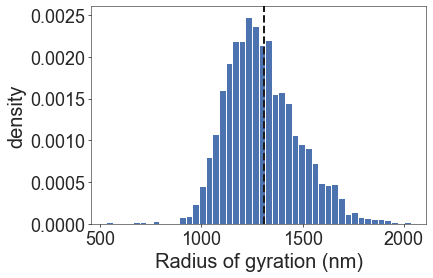

In [15]:
#radius of gyration histogram
Rg2 = []
for i in range(len(zxys_filtered)):
    posN = zxys_filtered[i][357:]
    Rg2.append(np.nanmean((posN - np.nanmean(posN, axis=0))**2) * 3)
meanRg2 = np.mean(Rg2)
print(f'Mean radius of gyration: {np.sqrt(meanRg2)} nm')
fig, ax = plt.subplots()
result = ax.hist(np.sqrt(Rg2), bins='auto', density=True)
plt.axvline(np.sqrt(meanRg2), color='k', linestyle='dashed')
ax.set_xlabel('Radius of gyration (nm)')
ax.set_ylabel('density')

In [16]:
from scipy.spatial.distance import squareform, pdist
distmap_qarm_list = np.array([squareform(pdist(_zxy[357:])) for _zxy in zxys_filtered])
mean_distance_map_qarm = np.nanmean(distmap_qarm_list, axis = 0)
# calculate contact freq map
contact_th = 500
contact_qarm_map = np.sum(distmap_qarm_list<contact_th, axis=0) / np.sum(np.isnan(distmap_qarm_list)==False, axis=0)

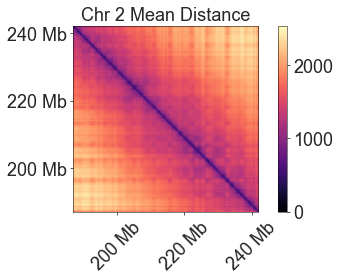

In [57]:
from plot_functions import plot_msd_map, plot_contact_map, expected, draw_power_law_triangle
plot_msd_map(mean_distance_map_qarm, qarm_start_Mb, qarm_end_Mb, 'chr_2_rep1_qarm', chrom='2')

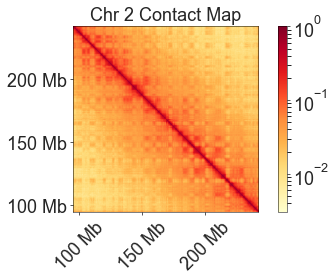

In [40]:
plot_contact_map(contact_qarm_map, qarm_start_Mb, qarm_end_Mb, 'chr2_rep1_qarm')

6.05498932613451e-01


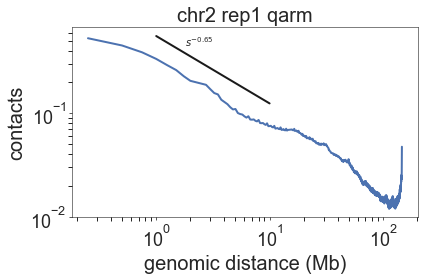

In [43]:
expected(contact_qarm_map, mid_position_Mb, triangle_x0=[0, -0.25], filename='chr2_rep1_qarm')

In [80]:
def obs_exp(mat, mask=None):
    """ Compute observed over expected from raw contact map by dividing each diagonal by the mean.
    
    Parameters
    ----------
    mat : np.ndarray[float] (N, N)
        contact map
    mask : np.ndarray[bool] (N, N)
        regions that are masked out
    """
    Pofs = np.zeros((mat.shape[0],))
    Pofs[0] = 1.0 #main diagonal -- 100% probability of contact
    if mask is None:
        mask = np.ones(mat.shape, dtype="bool")
    for k in range(1, mat.shape[0]):
        diag = np.diag(mat, k)
        mask_diag = np.diag(mask, k)
        Pofs[k] = np.nanmean(diag[mask_diag])
    exp = LazyToeplitz(Pofs)
    oe = mat / exp[:, :]
    return oe, Pofs

def plot_pofs(Pofs_curves, labels, colors=['r', 'b', 'grey'], scale_fit_start=2, scale_fit_end=30, slope=-1,
              figname=None, slope_offset=0.1, curve_scaling_ind=-1, xscale=1.0):
    fig, ax = plt.subplots()
    sdistances = np.concatenate((np.array([0.0]), np.cumsum(np.diff(mid_position_Mb))))
    for i, Pofs in enumerate(Pofs_curves):
        ax.plot(sdistances[1:], Pofs[1:], label=labels[i], color=colors[i])
    #extract scaling from one of the curves with curve_scaling_ind
    x = sdistances
    y = Pofs_curves[curve_scaling_ind]
    result = scipy.stats.linregress(np.log10(x)[(x > scale_fit_start) & (x <= scale_fit_end)], 
                                   np.log10(y)[(x > scale_fit_start) & (x <= scale_fit_end)])
    print(result.slope)
    ylo, yhi = ax.get_ylim()
    power_law_top = yhi + slope_offset*yhi
    print(yhi)
    if slope == "fit":
        slope = result.slope
    corner = draw_power_law_triangle(slope, [np.log10(scale_fit_start), np.log10(power_law_top)], 1.0, 'down', base=10,
                            hypotenuse_only=True, label=f'$s^{{{slope:.2f}}}$', label_padding=0.05,
                                    text_args={'fontsize' : 16})
    #ax.text(12.0, 0.006, r'$s^{-1}$', fontsize=16)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(left=2)
    ax.set_xlabel('genomic distance (Mb)')
    ax.set_ylabel(f'Expected (mean of diagonal)')
    plt.legend()
    fig.tight_layout()
    if figname:
        plt.savefig(f'../plots/pofs_{figname}.pdf')
    return fig, ax

def plot_scaling_from_contact_map(mat, **kwargs):
    ids = np.load('/net/levsha/share/deepti/data/ABidentities_chr2_q_Su2020.npy')
    #make a mask where B regions are masked out (1s for A-A contacts)
    Amask = np.outer(ids, ids).astype("bool")
    Bmask = ~Amask
    oe, pofs = obs_exp(mat)
    oe, A_pofs = obs_exp(mat, Amask)
    oe, B_pofs = obs_exp(mat, Bmask)
    fig, ax = plot_pofs([A_pofs, B_pofs, pofs], ['A', 'B', 'both'], **kwargs)
    ax.set_title(f"P(s) for chr2 q-arm")
    plt.savefig(f"../../plots/contact_scaling_chr2_qarm.pdf")

/tmp/ipykernel_23678/494523608.py:18: RuntimeWarning: Mean of empty slice
  Pofs[k] = np.nanmean(diag[mask_diag])
/tmp/ipykernel_23678/494523608.py:32: RuntimeWarning: divide by zero encountered in log10
  result = scipy.stats.linregress(np.log10(x)[(x > scale_fit_start) & (x <= scale_fit_end)],


-0.49895482456778495
0.6135306778801095


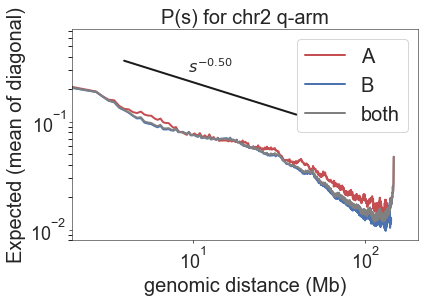

In [81]:
plot_scaling_from_contact_map(contact_qarm_map, scale_fit_start=4, scale_fit_end=50, slope_offset=-0.4, slope="fit")

# Visualize traced structures with nglview

In [17]:
import nglutils as ngu
import nglview as nv

In [26]:
def get_monomer_names_from_ids(ids=None):
    if ids is None:
        ids = np.load('/net/levsha/share/deepti/data/ABidentities_chr2_q_Su2020.npy')
    assert(np.all(np.logical_or(ids == 0, ids == 1)))
    N = len(ids)
    print(N)
    monomer_ids = np.zeros((N,), dtype=int)
    monomer_ids[ids==0] = 1 #type B(cold)
    monomer_ids[ids==1] = 0 #type A (hot)
    #convert integer monomer types to atom names
    monomer_names = ngu.intlist_to_alpha(monomer_ids)
    return monomer_names

def visualize_traced_structure(zxy, ids=None):
    monomer_names = get_monomer_names_from_ids(ids)
    #number of monomers in one subchain
    N = len(monomer_names)
    top = ngu.mdtop_for_polymer(N, atom_names=monomer_names)
    view = ngu.xyz2nglview(zxy, top=top)
    view.center()
    view.add_representation('ball+stick', selection='.A',
                                        colorScheme='uniform',
                                        colorValue=0xff4242)

    view.add_representation('ball+stick', selection='.B',
                                          colorScheme='uniform',
                                          colorValue=0x475FD0)
    return view

In [32]:
ids = np.load('/net/levsha/share/deepti/data/ABidentities_chr2_q_Su2020.npy')
zxy = zxys_filtered[100][357:]
#zxy -= np.mean(np.sqrt(np.sum(zxy**2, axis=1)))
view = visualize_traced_structure(zxy, ids=ids)
view

578


NGLWidget()

Text(0.5, 1.0, 'flat-bottomed potential')

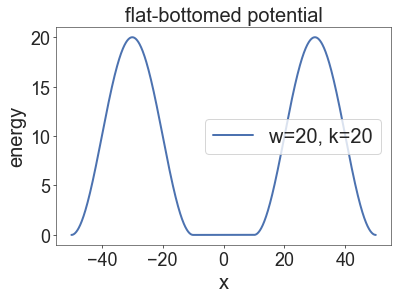

In [235]:
fig, ax = plt.subplots()

def spherical_well(x, x0=0.0, width=10.0, radius=18.0, depth=5.0):
    d = (np.sqrt((x - x0)**2) - radius) / width
    force = np.heaviside(1+d, 1) * np.heaviside(1-d, 1) * depth * (1 + np.cos(np.pi * d))/2
    return force

x = np.linspace(-50.0, 50.0, 1000)
#ax.plot(x, spherical_well(x, width=4.0, radius=14.0), label='w=4, k=5')
#ax.plot(x, spherical_well(x, width=10.0, radius=20.0), label='w=10, k=5')
ax.plot(x, spherical_well(x, width=20.0, radius=30.0, depth=20.0), label='w=20, k=20')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('energy')
ax.set_title('flat-bottomed potential')
#ax.plot(x, -np.gradient(spherical_well(x, width=20.0, radius=30.0, depth=20.0)))
#ax.plot(x, -np.gradient(spherical_well(x, width=40.0, radius=50.0, depth=60.0)))
#ax.set_xticks(np.arange(-15, 16, 1))

In [159]:
x = np.linspace(-15.0, 15.0, 1000)


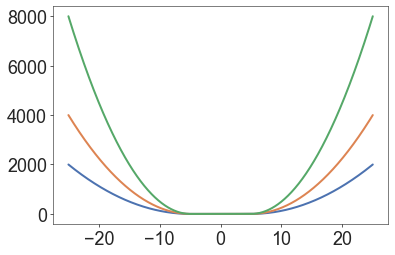

In [213]:
fig, ax = plt.subplots()

def harmonic_well(x, x0=0.0, radius=5.0, depth=5.0):
    d = (np.sqrt((x - x0)**2) - radius)
    force = np.heaviside(d, 1) * depth * d**2
    return force

x = np.linspace(-25.0, 25.0, 1000)
ax.plot(x, harmonic_well(x, depth=5))
ax.plot(x, harmonic_well(x, depth=10))
ax.plot(x, harmonic_well(x, depth=20))

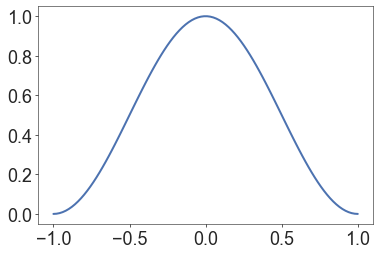

In [114]:
d = np.linspace(-1.0, 1.0, 100)
fig, ax = plt.subplots()
ax.plot(d, (1 + np.cos(np.pi * d))/2)

In [186]:
def square_lattice(n):
    dim = 3
    k, j, i = [v.flatten()
               for v in np.meshgrid(*([range(n)] * dim), indexing='ij')]
    df = pd.DataFrame({
        'x': i,
        'y': j,
        'z': k,
    })
    return df

df = square_lattice(3)
df

,x,y,z
0,0,0,0
1,1,0,0
2,2,0,0
3,0,1,0
4,1,1,0
5,2,1,0
6,0,2,0
7,1,2,0
8,2,2,0
9,0,0,1


In [202]:
n = 10
integer_squares = [i**3 for i in range(n)]
print(integer_squares)
np.searchsorted(integer_squares, 65)

[0, 1, 8, 27, 64, 125, 216, 343, 512, 729]


5